In [24]:
import time, csv, os, requests, copy

import numpy as np
from numpy.linalg import norm
from numpy.random import randn
from numpy import eye, array, asarray, exp
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float': '{: 6.4f}'.format})
from math import sqrt

#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
rcParams["font.serif"] = "cmr14"
rcParams['savefig.dpi'] = 300
rcParams["figure.dpi"] = 100
rcParams.update({'font.size': 18})
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update(params)

try: 
    import serial
except:
    !pip3 install pyserial
    import serial

DEG2RAD = np.pi/180.

import struct
from casadi import *
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

opts1 = {"expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-2, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

In [36]:
def Serial_write(U):
    # special bytes of a space and ! added for eps32 to find start
    buf = struct.pack('%sf' % len(U), *U)
    ser.write(bytearray(b' ')+bytearray(b'!')+buf)

def Request_data(ser):
    # special bytes of a space and & to request data
    ser.write(bytearray(b' ')+bytearray(b'&'))

def Reset_imu(ser):
    # special bytes of a space and + to redo calib
    ser.write(bytearray(b' ')+bytearray(b'+'))

def smootherstep(edge0, edge1, x): 
    # Scale, and clamp x to 0..1 range
    x = np.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    # Evaluate polynomial
    return x * x * x * (x * (x * 6 - 15) + 10)

def Read_data(ser):
    nvar = 5 # 4 floats and checksum
    str_len = 4*nvar
    found_header = False
    tic = time.time()
    data = np.zeros(7)
    for kk in range(str_len+1):     # look for header
        if (ser.read(1) == b'&'):
            if (ser.read(1) == b'!'):
                found_header = True
                break
    if found_header:
        rbytes = ser.read(str_len)
        if (len(rbytes) == str_len):
            try:
                for ii in range(nvar):
                    data[ii] = struct.unpack('f',rbytes[4*ii:4*(ii+1)])[0]
                data[5] = time.time() - tic
                data[6] = np.abs(data[4] - np.sum(data[0:4])) # checksum
                return data
            except:
                data[6] = -1
                return data
        else:
            data[6] = -2
        return data # will be zero if 
    data[6] = -3
    return data

In [37]:
class Model():
    def __init__ (self):
        self.N = 10 # MPC steps
        self.Fs = 1/0.033 #Hz
        self.Ts = 1/self.Fs
        self.Tf = self.N*self.Ts # MPC plan horizon
        self.opti = None
        self.params = None
        self.sol = None
        self.Umax = 500 # system params
        self.omega_n2 = (5.3761)**2 # measured
        self.damping = 2*0.0485*5.3761 # measured
        self.gain =  40/100/57.3 # measured
        self.A = np.array([[0.0, 1.0],[-self.omega_n2, -self.damping]])
        self.B = np.array([[0.0,self.gain*self.omega_n2]])

    def deriv(self,x,u): #MPC design model
            #return vertcat(x[1], -Pend.omega_n2 *x[0] -Pend.damping*x[1] + Pend.B[:,1][0] * u) 
            #return vertcat(x[1], -Pend.omega_n2 *np.sin(x[0]) -Pend.damping*x[1] + Pend.B[:,1][0] * u) 
            return vertcat(x[1], Pend.A[1,0]*np.sin(x[0]) + Pend.A[1,1]*x[1] + Pend.B[:,1][0] * u) 


#Fd = 0.8546
#wd = 5.3697
#zeta = 0.0485
#wn = 5.3761
       

In [38]:
try:
    ser.close()
except:
    pass

Nplot = 1000

if 1:
    port = '/dev/cu.usbserial-110'
    #port = '/dev/cu.usbserial-10'
    ser = serial.Serial(port,baudrate=115200,timeout=0.001)
    ser.flushInput()
    ser.write(bytearray(b'R'))
    time.sleep(10)

In [39]:
def makeFig():
    plt.plot(etime[-Npts:],theta[-Npts:],'b-',label='theta')
    plt.plot(etime[-Npts:],gyro[-Npts:],'r--',label='gyro')
    plt.legend(loc=3)


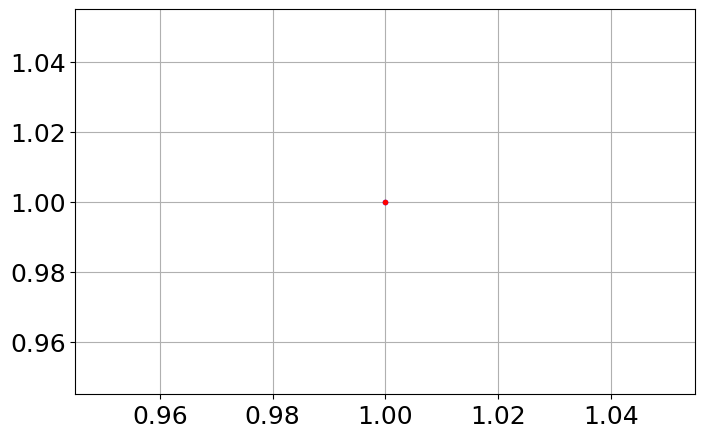

In [40]:
from drawnow import *
import time
etime = [1]
theta = [1]
gyro = [1]

fig, ax = plt.subplots()
ax.plot(etime[-50:],theta[-50:],'b.--',label='theta')
ax.plot(etime[-50:],gyro[-50:],'r.-',label='gyro')


In [41]:
fig, ax = plt.subplots(figsize=(16,8))
for ii in range(Nplot):
    Request_data(ser)
    time.sleep(0.001)
    data = Read_data(ser)
    if data[6] > 0: # good data
        etime = np.append(etime,data[0])
        theta = np.append(theta,data[1])
        gyro = np.append(gyro,data[2]*np.pi/180.)
    if (ii%25 == 0): 
        drawnow(makeFig)


NameError: name 'Npts' is not defined

<Figure size 1600x800 with 0 Axes>